# Exercise 14: Simple metadynamics: the dissociation of nitric acid on graphene

Molecular and Materials Modelling: ETH Zürich, FS 2023

Date: Wednesday, 31. May 2023

Due date: none

Raymond Amador, Daniele Passerone, Carlo Pignedoli

## 0. Introduction

In this exercise we will study the dissociation reaction of nitric acid on graphene described using coordination numbers. This simulation will illustrate a simple metadynamics run using the coordination numbers as variables. In order to examine these two phenomena, we will complete the following tasks:

* Set up preliminary simulations to learn about the dynamics of nitric acid on graphene at the **density-functional tight binding** (DFTB) level of theory
* Restrict the configuration space to "interesting" situations by limiting the movement of the two $\text{HNO}_3$ molecules via introduction of an external potential
* Establish a set of collective variables (CVs) to learn about the typical behaviour of any particular CV along an unbiased MD run
* Employ a metadynamics simulation to trigger the dissociation of nitric acid by following changes of three different coordination numbers

<div>
<img src="HNO3_graphene.png" width="900"/>
</div>

### 0.1. Density-functional tight binding

The level of theory for the present exercise is that of **density-functional tight binding**, whereby the electronic density $\rho (r)=\rho_0 + \delta \rho (r)$ is expanded about a reference density $\rho_0(r)$:

\begin{align*}
    E[\rho(r)] = & \int \delta \rho(\textbf{r}) \frac{E[\rho(r)]}{\delta \rho(\textbf{r})} \Bigg\rvert_{\rho_0} & \\
    & +  \frac{1}{2} \int \delta \rho(\textbf{r}) \delta \rho(\textbf{r'}) \frac{\delta^2E[\rho(\textbf{r})]}{\delta \rho(\textbf{r}) \delta \rho(\textbf{r'})}\Bigg\rvert_{\rho_0} + \dots & \\ 
    & + \frac{1}{p!} \int \dots \int \delta \rho(\textbf{r}) \delta \rho(\textbf{r'}) \dots \delta \rho(\textbf{r}^{(p)}) \frac{\delta^p E[\rho(r)]}{\delta \rho(\textbf{r}) \delta \rho(\textbf{r'}) \dots \delta \rho(\textbf{r}^{(p)})}\Bigg\rvert_{\rho_0} &
\end{align*}

We refer to the relevant literature for a more thorough discussion on the theory. Nonetheless: DFTB presents a few computational advantages, in particular with regard to scaling, in comparison to standard DFT by (in some respects) combining the computational accuracy of DFT with the efficiency of TB, especially in systems where the electrons can be considered tightly bound.

# 1. The dynamics of two $\text{HNO}_3$ molecules over a graphene sheet

The goal of this first task is to simulate the dissociation of $\text{HNO}_3$ molecules with formation of products like $\text{H}_2\text{O}$ and/or $\text{NO}$ or $\text{NO}_2$ fragments. These reactions can occur in the gas phase; however, the reaction should be catalyzed in the presence of C atoms (engl. *soot*; dt. *Glanz- bzw. Hartruss*). In the proposed example, the molecules are located in the vicinity of graphene, which should mimic the role of soot. Graphene is indeed not very reactive, and so better models can be considered using defective or functionalized graphene. 

We begin by logging into our accounts on JupyterHub on Euler in a similar manner as described in the previous exercises, and `pull` the newest exercise files from the GitHub repository, making sure that you are in the directory for the course:
```bash
    $ cd ~/Molecular-and-Materials-Modelling-FS2023
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
```

The investigation begins with a simple *molecular dynamics* (MD) simulation at a constant temperature of 300 K to learn about the dynamics of the two molecules on graphene. The DFTB description is employed to speed up the simulation, even if this might not be the optimal choice to faithfully describe the dissociation reaction.

In the `gr2hno3_nvt.inp` input file, the section pertaining to DFTB is`

```
  .....
  &DFT
    &QS
      METHOD DFTB
      &DFTB
        SELF_CONSISTENT    T            
        DO_EWALD           T        ! use Ewald-type method instead of direct 
                                    sum for the Coulomb interaction
        DISPERSION         T        ! use dispersion
        &PARAMETER
          PARAM_FILE_PATH  ${LIBPATH}/scc
          PARAM_FILE_NAME  scc_parameter
          UFF_FORCE_FIELD  uff_table
        &END PARAMETER
      &END DFTB
    &END QS
    &POISSON
      PERIODIC XYZ
      &EWALD
       EWALD_TYPE SPME
       GMAX 25
       O_SPLINE 5
      &END EWALD
    &END POISSON
    ....
```

The keyword `PARAM_FILE_PATH` specifies the location of the library, in which the arguments for the next two keywords, `PARAM_FILE_NAME` and `UFF_FORCE_FIELD`, are to be found. Modify the argument of the `PARAM_FILE_PATH` parameter so that it correctly accesses the \texttt{scc} subdirectory, which is in turn, contained within the \texttt{DFTB} directory.

We need to copy the `DFTB` directory from the CP2K data directory, `CP2K_DATA_DIR`, to our current directory.

The system is fully periodic, and enough space is left above the graphene layer in order to avoid interactions with the images along $z$. This represents a very simple model of the type of particles which might trigger the dissociation reaction, and we are not interested in the dynamics of the layer itself. Therefore, a few atoms of the layer are constrained to fixed positions by 

```
  &CONSTRAINT
    &FIXED_ATOMS
      LIST    48 51 54 57 60 45 59 44 58 43
    &END
  &END
```

Change the `RESTART` files as necessary. Otherwise, the `MOTION` section is quite standard for NVT simulations. Since the total number of degrees of freedom is small, even with the thermostat the equilibration to the desired temperature might prove to be difficult. In this light, the rescaling of the temperature is activated by the `TEMP_TOL` keyword, whenever the difference between the instantaneous temperature and the desired value exceeds the given tolerance.

In [1]:
import numpy as np
import sys
import scipy
from scipy.special import sph_harm
from glob import glob
from ase.io import read,write
from ase import neighborlist,Atoms,Atom
from ase.build import molecule
import matplotlib.pyplot as plt
from ase.visualize import view
import nglview as nv

In [2]:
def view_structure(system):
    t = nv.ASEStructure(system) 
    w = nv.NGLWidget(t, gui=True)
    w.add_spacefill()
    return w

In [3]:
def view_trajectory(system):
    t2 = nv.ASETrajectory(system)
    w2 = nv.NGLWidget(t2, gui=True)
    #w2.add_spacefill()
    return w2

## Viewing structures template

In [20]:
dynamics1=read('file.xyz')

In [ ]:
view_structure(variable)

## Viewing trajectories template

In [4]:
dynamics1=read('gr2hno3_nvt-pos-1.xyz', index=":") #the index parameter is important...

In [5]:
view_trajectory(dynamics1)

NGLWidget(max_frame=200)

In [11]:
dynamics2=read('gr2hno3_nvt_epot-pos-1.xyz', index=":")

In [12]:
view_trajectory(dynamics2)

NGLWidget(max_frame=200)

In [10]:
dynamics3 = read('gr2hno3_mtd_4cv_h0_p1-pos-1.xyz', index=":")

In [11]:
view_trajectory(dynamics3)

NGLWidget(max_frame=20000)

In [4]:
dynamics4 = read('./MTD-new/gr2hno3_mtd_3cv_p1-pos-1.xyz', index=":")

In [5]:
view_trajectory(dynamics4)

NGLWidget(max_frame=200)

#### Assignment 1: Densitfy-funcitonal tight binding (DFTB)

Submit the calculation as usual:

(or use the run script from the previous exercise). The output of this short 5ps simulaiton is stored in `DFTB_NVT`. The kinetic energy (3rd column), temperature (4th), potential energy (5th), and total energy (6th) can be viewed in the `gr2hno3\_nvt-1.ener` file. Visualize the trajectory in a Python notebook. By visualizing the short trajectory, it is observed that the two molecules move very fast, and explore a large portion of configuration space, being often far from each other and far from graphene.

**Estimated runtime on one node: 75min** (probably best to use the run script from last week.)

In [ ]:
## Your code here

#### End Assignment 1

In order to restrict the exploration to regions where the dissociation catalyzed by graphene might occur (and thereby avoiding configurations that are not interesting for this specific study), it is necessary to limit the movement of the two molecules. To this end, an external potential defining a spherical potential centered on the center of the system coordinates is added, which acts only on the two molecules and creates a wall around the "interesting" part of the energy. In order to simplify the definition of the external potential, the coordinates are first centered at zero; these new coordinates can be found in the `grly5x3_2hno3_cc.xyz` file. The ~~new~~ updated input file invoking the interaction with this spherical potential is `gr2hno3_nvt_epot.inp`, in which the only difference to the first input file is to be found in the `&FORCE_EVAL` section:

```
  &EXTERNAL_POTENTIAL
     ATOMS_LIST   61..70
     FUNCTION   0.000000000001*(Z^2)^4
  &END

  &EXTERNAL_POTENTIAL
     ATOMS_LIST   61..70
     FUNCTION   0.0000000000001*(X^2)^4
  &END

  &EXTERNAL_POTENTIAL
     ATOMS_LIST   61..70
     FUNCTION   0.0000000000001*(Y^2)^4
  &END
```

#### Assignment 2: Using the external potential

Change the `RESTART` files as necessary and run the simulation. Now, along this resulting 10ps trajectory, the two molecules remain close to graphene, where they should be. Visualize the trajectory and comment on the results.

**Estimated runtime on one node: 75min**

In [ ]:
## Your code here

#### End Assignment 2

## 3. Choosing the collective variables (CVs)

The next step is to set up the CVs which will be later used for the **metadynamics** (MTD) simulations. As we had seen last week, it is important to select good CVs that can describe the relevant configuration along the reaction pathway. Moreover, it is useful to learn about the typical behaviour of the selected CV along an unbiased MD run. Hence, after selecting a set of CVs, preliminary runs should be performed in order to monitor the dynamics of these variables. This can be done setting up MTD simulations, where in fact, no bias is added. The evolution of the variables is then monitored while the system explores the configurations around the initial one, i.e., belonging to the same (initial) basin of attraction on the **free energy surface** (FES), which we also met last week. 

The evaluation of typical fluctuation amplitudes of the CVs is particularly important in order to set the width of the Gaussian beads which are going to build up the penalty potential along the "real" MTD run. Moreover, it is important to learn which variations in the CV can occur spontaneously, i.e., those that do not require any bias, and where the CV cannot move without activation.

### 3.1. The C-O coordination number

The input file `gr2hno3_mtd_4cv_h0_p1.inp` has been prepared, establishing and defining our four CVs. Open this input file. The first CV is the **coordination number** (CN) of O to graphene:

```
&COLVAR
    &COORDINATION
        KINDS_FROM  O
        KINDS_TO   C
        R_0 [angstrom]  1.8
        NN  8
        ND  14
    &END COORDINATION
&END COLVAR
```

where both `NN` and `ND` determine the curvature of the function used to compute the CN, and `R_0` is the reference C-O distance. Then this CV, denoted $CN_{CO}$ and given by

\begin{equation*}
    CN_{CO} = \frac{1}{N_O} \sum_{i_O} \sum_{j_C} \frac{1-(\frac{r_{ij}}{R_0})^{NN}}{1-(\frac{r_{ij}}{R_0})^{ND}}
\end{equation*}

describes the interaction between those O atoms which might dissociate from N, and graphene, where adsorption might occur. Moreover, $CN_{CO}$ should be approximately zero when the molecules are far from the layer; it becomes larger than zero, but always smaller than unity, when one or more O gets closer to the layer. With our given parameters, the CN starts being larger than zero for C-O distances below 4 \AA. 

### 3.2 The N-O coordination number

The second CV is the CN of N to O, which is approximately 3 for non-dissociated molecules, and smaller when the dissociation begins.

```
    &COLVAR
       &COORDINATION
          KINDS_FROM  N
          KINDS_TO   O
          R_0 [angstrom]  1.8
          NN  8 
          ND  14
       &END COORDINATION
    &END COLVAR
```

### 3.3. The H-C coordination number

The third CV is the coordination number between H and graphene, since also H can be lost from the molecules and subsequently adsorbed onto graphene:

```
    &COLVAR
       &COORDINATION
          KINDS_FROM  H
          KINDS_TO   C
          R_0 [angstrom]  1.6
          NN  8
          ND  14
       &END COORDINATION
    &END COLVAR
```

### 3.4. The distance between point and plane

The fourth and final CV is the distance between a point and a plane, whereby the point is the geometric center between the two N atoms of the system, and the plane is determined (uniquely! This seemingly trivial and almost taken-for-granted factum has its origins (of course) in Euclid's *Elements*. In particular, his proof of Prop. 5 in Book IV can be generalized to the theorem *any three noncollinear points determine a plane*.) by the coordinates of three C species of graphene: 

```
&COLVAR
    &DISTANCE_POINT_PLANE
    &POINT
        TYPE GEO_CENTER
        ATOMS 1
    &END
    &POINT
        TYPE GEO_CENTER
        ATOMS 48
    &END
    &POINT
        TYPE GEO_CENTER
        ATOMS 60
    &END
    &POINT
        TYPE GEO_CENTER
        ATOMS  69 70
    &END
        ATOMS_PLANE 1 2 3 
        ATOM_POINT 4
    &END DISTANCE_POINT_PLANE
&END COLVAR
```
This last CV restrains the distance of the molecules from the layer, which is an important factor to determine whether dissociation is somehow favoured by the presence of graphene. The output of the unbiased MD run that monitors the behaviour of these 4 CV is contained in DFTB_MTD_4CV_H0`, and is obtained by invoking an MTD run where no penalty potential is added.

Hence, the `&FREE_ENERGY` subsection is added within the section `&MOTION`; the MTD run is controlled from the `&METADYN` subsection. In the present case, where no bias has to be added, the `&METADYN` section contains comparatively few parameters:

```
  &FREE_ENERGY
    &METADYN
      DO_HILLS  .FALSE.

      &METAVAR
        SCALE 0.08
        COLVAR 1
      &END METAVAR

      &METAVAR
        SCALE 0.3
        COLVAR 2
      &END METAVAR

     &METAVAR
        SCALE 0.08
        COLVAR 3
      &END METAVAR

      &METAVAR
        SCALE 1.5
        COLVAR 4
      &END METAVAR

      &PRINT
        &COLVAR
           COMMON_ITERATION_LEVELS 3
           &EACH
             MD 1
           &END
        &END
      &END
    &END METADYN
  &END FREE_ENERGY
```

Change the `RESTART` files as necessary. With the `.FALSE.` argument fed to the `DO_HILLS` parameter, it is required that no bias is added. Then, for each defined `COLVAR`, a MTD variable is initialized. The `PRINT%COLVAR` section controls the printing of the `COLVAR` output file, containing the instantaneous values of the CV as well as other parameters when needed. For the run without bias, no other information is needed, and the only interesting data in the `gr2hno3_mtd_4cv_h0_p1-COLVAR.metadynLog` are the second, third, fourth, and fifth columns, which are instantaneous values of the CV at the respective time (in fs, first column).

#### Assignment 3: Time dependence of various CVs: skeleton

By plotting the CVs against time, the amplitude of the equilibrium fluctuations can be evaluated and then used to set up the size of the Gaussian hills that build up the biasing potential. In this exercise, we will generate a total of three plots.

The first CV (C-O coordination number) fluctuates close to zero, with fluctuations smaller than 0.2; the second CV (N-O coordination number) is around 2.8, with fluctuations smaller due to the stiffness of the three NO bonds. Generate this plot.

The third CV (H-C coordination number) is also typically zero, yet can change quite significantly when the  molecules approach the layer, even if there is no dissociation of H, and no binding to C. This indicates that this variable is difficult to control and might turn out to be tricky to use to distinguish amongst different states of the reaction process. Generate this plot as well.

Finally, generate the plot of the fourth CV (point-plane distance). This plot shows quite large fluctuations and is clearly not suited to distinguish a specific state along the reaction path. Moreover, its minima, when the two molecules are closer to the layer, correspond to the maxima of the third CV, i.e., to the CN of H-C. At least prior to dissociation, the information that this variable provides is redundant.

Nonetheless, it might be interesting to run again this preliminary simulation after modifying the definition of the CV. For example, by changing the two exponents or even the reference distance of the CN, the range of the function can be made shorter or longer. It is maybe important to remind ourselves that the function defining the CV must have a gradient different from zero to affect the behaviour of the system in a MTD run. In more exact words: the MTD force term affecting the dynamics of the atoms involved in the definition of the CV is proportional to the CV function.

In [7]:
with open("gr2hno3_mtd_4cv_h0_p1-COLVAR.metadynLog") as f:
    lines = f.readlines()

In [8]:
time=[float(i.split()[0]) for i in lines]

In [9]:
CO_CN=[float(i.split()[1]) for i in lines]

Text(0.5, 0, 'time (fs)')

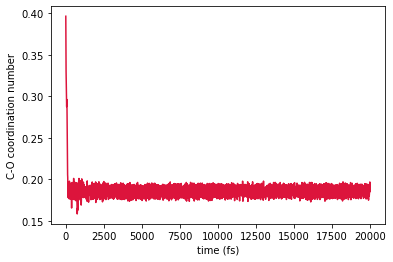

In [10]:
fig = plt.plot(time,CO_CN,color='crimson')
#get the axis just defined
ax  = plt.gca()
ax.set_ylabel("C-O coordination number")
ax.set_xlabel("time (fs)")

In [ ]:
## Your code here

#### End Assignment 3

## 4. The metadynamics of the dissociation

Now, for the metadynamics of the dissociation of $\text{HNO}_3$ on a graphene sheet, we remove the point-plane distance as a CV, and thereby employ only the three CNs as CVs as described above. The input file is `gr2hno3_mtd_3cv_p1.inp`, whose input file has already been modified to activate the MTD algorithm:

```
&METADYN
    DO_HILLS 
    NT_HILLS 100
    WW 3.0e-3
    &METAVAR
    SCALE 0.2
    COLVAR 1
    &END METAVAR
    &METAVAR
    SCALE 0.3
    COLVAR 2
    &END METAVAR
    &METAVAR
    SCALE 0.2
    COLVAR 3
    &END METAVAR
    &PRINT
    &COLVAR
        COMMON_ITERATION_LEVELS 3
        &EACH
            MD 1
        &END
    &END
    &HILLS
        COMMON_ITERATION_LEVELS 3
        &EACH
            MD 1
        &END
    &END
    &END
&END METADYN
```

One Gaussian hill is dropped for every number of steps specified in the `NT_HILLS` parameter; the height of the hill (in Ha) is given by `WW`. These parameters, together with the width of the Gaussian hills, are important to determine the accuracy of the description of the FES via the MTD biasing potential. Since each variable has, in principle, different dimensions and different dynamics, the shape of the hills filling up the $N_{CV}$-dimensional configuration space, as defined by the selected CVs themselves, is *not* isotropic: rather, the parameter `SCALE` associated to the $i$th MTD variable determines the amplitude of the Gaussian in the $i$th space direction of the $N_{CV}$-dimensional configuration space.

This parameter, as well as the hill's height and the frequency of collocation, can be changed along the same MTD run by restarting with different values in the input. This feature is useful when the dynamics of some variable changes after some event has occurred (e.g., the fluctuation of a distances becomes larger after a bond breaks), or to modulate the resolution of the biasing potential (coarser or finer) in different regions of the phase space (e.g., coarser at the bottom of the FES basin, and finer in the vicinity of the transition state).

For an efficient exploration of configuration space, it is crucial to spawn hills that are neither too big, lest important features of the topography of the FES might not be sufficiently well resolved, or even the MTD trajectory could follow the wrong path, thereby missing the **minimum energy path** (MEP). On the other hand, filling up the whole space with hills which are too small might require excessively long  simulation time. Given the hill size (height and width), and knowing (approximately) the size of the space spanned by the CVs and the barrier height, it is possible to estimate the number of hills needed to fill the basin of the FES and move to the next minimum.

The `HILLS` keyword controls the printing of the `HILLS` file, where the information on the spawned hills is stored: timestep, coordinates of the center in the space of CVs (three CVs means three columns), followed by the width of the hill in each Cartesian direction of space (three more columns), followed by the height (last column).

#### Assignment 4: Analysis of the MTD output files and generation of the FES

Submit the calculation and then view the trajectory of the output. The provided trajectory is about 100 ps, and indeed shows the dissociation of the two molecules into $\text{NO}_2$ and OH, whereby the OH fragments tend to interact with the graphene layer. From the behaviour of the first and second CNs, the evolution of the system can be somehow deduced. In particular, there are clear changes in the N-O CN, which becomes larger when the two molecules get closer to each other, and becomes smaller when the OH is dissociated.

Soon after the dissociation, the coordination is again close to 3, because the lost O is compensated by the fact that the two $\text{NO}_2$ fragments stay close together, i.e., each N sees the O of the other fragments. The C-O CN becomes larger when the molecules are closer to the layer, and fluctuates quite a lot due to the rapid movement of the molecules. After the dissociation, higher values of the CN are kept for longer time, indicating some more stable interaction of O with C.

A better choice of the parameters defining the C-O CN might help resolve more clearly the two states: O interacting and O not interacting with the layer. As predicted, the`very large fluctuations of the H-C CN are difficult to interpret and make this variable not particularly useful for the description of the process. In this light, a CN of N-H, describing the dissociation of H from $\text{HNO}_3$, might have been resp. might be a better choice as a third CV.

Other quantities that can be monitored from the `COLVAR` output, besides the instantaneous values of the three CVs (2nd, 3rd, 4th columns, resp.) are: the instantaneous gradient of the bias potential computed with respect to the CV (5th, 6th, 7th col.); the gradients with respect to the CVs of the wall potentials, if present (8th, 9th, 10th col.); the instantaneous value of the bias potential (11th col.), and the instantaneous values of the wall potentials (12th col.).

**Estimated runtime on one node: 100min**

In [11]:
bohr_2_angstrom = 0.529177
kb = 8.6173303e-5 # eV * K^-1

temperature = 300.0                          #Change temperature according to your MD simulations!
colvar_path = "./gr2hno3_mtd_3cv_p1-COLVAR.metadynLog"

# Load the colvar file
colvar_raw = np.loadtxt(colvar_path)

# Extract the two CVs
d1 = colvar_raw[:, 2] * bohr_2_angstrom
d2 = colvar_raw[:, 3] * bohr_2_angstrom

# Create a 2d histogram corresponding to the CV occurances
cv_hist = np.histogram2d(d1, d2, bins=500)

# probability from the histogram
prob = cv_hist[0]/len(d1)

# Free energy surface
fes = -kb * temperature * np.log(prob)

# Save the image
extent = (np.min(cv_hist[1]), np.max(cv_hist[1]), np.min(cv_hist[2]), np.max(cv_hist[2]))
plt.figure(figsize=(5, 5))
plt.imshow(fes.T, extent=extent, aspect='auto', origin='lower', cmap='hsv')
cbar = plt.colorbar()
cbar.set_label("Free energy [eV]")
plt.xlim(1.546,1.556)
plt.ylim(0.04, 0.065)
plt.xlabel("d1 [ang]")
plt.ylabel("d2 [ang]")
plt.savefig("./fes3.png", dpi=200)
plt.close()

<ipython-input-11-1417fc8278c0>:21: RuntimeWarning: divide by zero encountered in log
  fes = -kb * temperature * np.log(prob)
